# 프로젝트_네이버 영화리뷰 감성분석 도전하기

한국어 텍스트의 감정분석을 진행해보자.

활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)이다.

## 1. 데이터 준비와 확인

In [1]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 데이터의 크기 확인
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

## 2. 데이터로더 구성

---

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

+ 데이터의 중복 제거
+ NaN 결측치 제거
+ 한국어 토크나이저로 토큰화
+ 불용어(Stopwords) 제거
+ 사전word_to_index 구성
+ 텍스트 스트링을 사전 인덱스 스트링으로 변환
+ X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
len(index_to_word), index_to_word[5]

(10000, '영화')

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
sentences = ['안녕하세요 제 이름은 박민기입니다.', '별명은 요술공주밍키입니다.', '잘 부탁드립니다.', '좋아합니다.']
print(get_encoded_sentence('안녕하세요 제 이름은 박민기입니다.', word_to_index))
print(get_encoded_sentences(sentences, word_to_index))

[1, 2, 346, 2, 2]
[[1, 2, 346, 2, 2], [1, 2, 2], [1, 2, 2], [1, 2]]


## 3. 모델구성을 위한 데이터 분석 및 가공

---

+ 데이터셋 내 문장 길이 분포
+ 적절한 최대 문장 길이 지정
+ keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
# # 에러가 발생한다.
# vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10000
# word_vector_dim = 6    # 위 그림과 같이 4차원의 워드벡터를 가정합니다. 

# embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# # 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# # list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.
# raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
# output = embedding(raw_inputs)
# print(output)

/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [8]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[  1   2 346   2   2]
 [  1   2   2   0   0]
 [  1   2   2   0   0]
 [  1   2   0   0   0]]


In [9]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10,000
word_vector_dim = 5    # 그림과 같이 4차원의 워드벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.00725644  0.01198421 -0.04924512 -0.03726283 -0.04633215]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.04035126 -0.02675133 -0.0446048   0.00527745  0.04382864]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]]

 [[ 0.00725644  0.01198421 -0.04924512 -0.03726283 -0.04633215]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.02284347 -0.03635906 -0.04206822  0.03264039 -0.01381816]
  [ 0.02284347 -0.03635906 -0.04206822  0.03264039 -0.01381816]]

 [[ 0.00725644  0.01198421 -0.04924512 -0.03726283 -0.04633215]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.00496249  0.04212192 -0.02402248  0.03519756  0.02118469]
  [ 0.02284347 -0.03635906 -0.04206822  0.03264039 -0.01381816]
  [ 0.02284347 -0.03635906 -0.04206822  0.03264039 -0.01381816]]

 [[ 0.00725644  0.01198

/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


## 4. 모델구성 및 validation set 구성

---

모델 3가지 이상 구성해보기

### LSTM

In [10]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 5  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 5)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 448       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 50,529
Trainable params: 50,529
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

In [11]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [12]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [13]:
print(index_to_word[5])     # 'the' 가 출력됩니다. 
print(word_to_index['영화'])  # 1 이 출력됩니다.

영화
5


In [14]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [15]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  54
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(146182, 54) (146182,)
(49157, 54) (49157,)


### RNN 모델의 LSTM 레이어

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [18]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 54)
(136182,)


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 19ms/step - loss: 0.6434 - accuracy: 0.6062 - val_loss: 0.4993 - val_accuracy: 0.8037
Epoch 2/20
266/266 [==============================] - 5s 20ms/step - loss: 0.5065 - accuracy: 0.7923 - val_loss: 0.4741 - val_accuracy: 0.8149
Epoch 3/20
266/266 [==============================] - 5s 20ms/step - loss: 0.4740 - accuracy: 0.8174 - val_loss: 0.4694 - val_accuracy: 0.8210
Epoch 4/20
266/266 [==============================] - 5s 19ms/step - loss: 0.4698 - accuracy: 0.8194 - val_loss: 0.4754 - val_accuracy: 0.8137
Epoch 5/20
266/266 [==============================] - 5s 18ms/step - loss: 0.5712 - accuracy: 0.6983 - val_loss: 0.5020 - val_accuracy: 0.7927
Epoch 6/20
266/266 [==============================] - 5s 18ms/step - loss: 0.4901 - accuracy: 0.8016 - val_loss: 0.4887 - val_accuracy: 0.8072
Epoch 7/20
266/266 [==============================] - 5s 18ms/step - loss: 0.5040 - accuracy: 0.7959 - val_loss: 0.5152 - val_accuracy: 0.7884

In [20]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4984 - accuracy: 0.8013
[0.4983876943588257, 0.8012897372245789]


In [21]:
# # validtation을 사용하지 않고 해보기
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# history = model.fit(X_train,
#                     y_train,
#                     epochs=epochs,
#                     batch_size=512,
#                     verbose=1)

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4984 - accuracy: 0.8013
[0.4983876943588257, 0.8012897372245789]


## 6. Loss, Accuracy 그래프 시각화

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


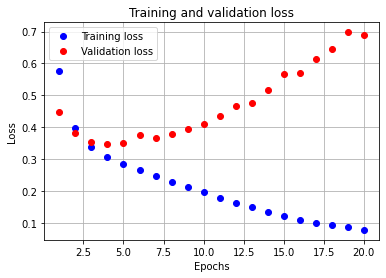

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

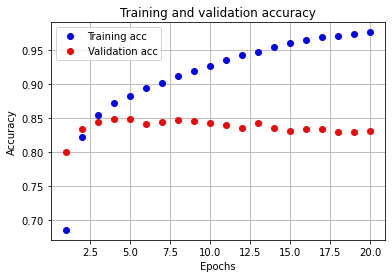

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [26]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [27]:
len(index_to_word)

10000

In [28]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
# 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.22421193, -0.20838356,  0.00815453, -0.0966987 , -0.16090102,
       -0.00667453,  0.2044427 , -0.20025073, -0.25150052, -0.21116234,
        0.05342022, -0.21652238, -0.13935912,  0.19619052,  0.16827284,
        0.2550035 ], dtype=float32)

In [30]:
# 유사도 확인하기
word_vectors.similar_by_word("사랑")

[('재밌', 0.9762435555458069),
 ('뭉클', 0.9729483127593994),
 ('저희', 0.9719141721725464),
 ('귀여워', 0.9698019623756409),
 ('찾아봐도', 0.9693699479103088),
 ('슬프', 0.9691429138183594),
 ('완벽', 0.96879643201828),
 ('가슴', 0.968731164932251),
 ('느낀다', 0.9684343338012695),
 ('질투', 0.9667683243751526)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

---

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://github.com/Kyubyong/wordvectors

In [31]:
import gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path)
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape    # 무려 200dim의 워드 벡터입니다.

/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [32]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("사랑")

/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac28/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 16s 59ms/step - loss: 0.6100 - accuracy: 0.6269 - val_loss: 0.4411 - val_accuracy: 0.8037
Epoch 2/20
266/266 [==============================] - 15s 57ms/step - loss: 0.3840 - accuracy: 0.8348 - val_loss: 0.3538 - val_accuracy: 0.8466
Epoch 3/20
266/266 [==============================] - 15s 57ms/step - loss: 0.3283 - accuracy: 0.8626 - val_loss: 0.3401 - val_accuracy: 0.8519
Epoch 4/20
266/266 [==============================] - 15s 57ms/step - loss: 0.3036 - accuracy: 0.8735 - val_loss: 0.3404 - val_accuracy: 0.8519
Epoch 5/20
266/266 [==============================] - 15s 58ms/step - loss: 0.2863 - accuracy: 0.8827 - val_loss: 0.3387 - val_accuracy: 0.8550
Epoch 6/20
266/266 [==============================] - 15s 58ms/step - loss: 0.2721 - accuracy: 0.8891 - val_loss: 0.3379 - val_accuracy: 0.8542
Epoch 7/20
266/266 [==============================] - 15s 58ms/step - loss: 0.2591 - accuracy: 0.8953 - val_loss: 0.3428 - val_accuracy:

In [44]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4651 - accuracy: 0.8408
[0.4650667607784271, 0.8407958149909973]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


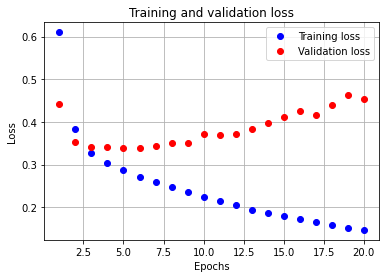

In [45]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

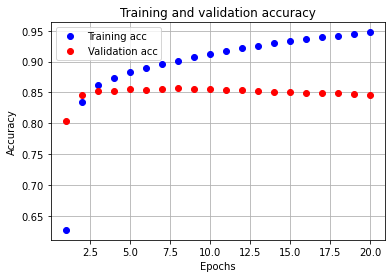

In [46]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

## 9. 다른 모델 사용해보기

### 9.1 1-D Convolution Neural Network(1-D CNN)

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

print(model.summary())


# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### 9.2 GlobalMaxPooling1D

In [48]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

print(model.summary())


# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
266/266 [==============================] - 8s 29ms/step - loss: 0.6580 - accuracy: 0.5986 - val_loss: 0.5974 - val_accuracy: 0.6819
Epoch 2/20
266/266 [==============================] - 8s 29ms/step - loss: 0.5536 - accuracy: 

## 10. 마치며

### 10.1 정리

1. 결과
    - 임베딩 하지 않은 RNN 모델의 LSTM 레이어 : accuracy 0.8013
    - 임베딩한 RNN 모델의 LSTM 레이어 : accuracy 0.8408
    - 임베딩한 1-D Convolution Neural Network(1-D CNN) 모델 : accuracy 0.8318
    - 임베딩한 GlobalMaxPooling1D 모델 : accuracy 0.8297

2. gensim의 유사단어 찾기를 활용해서 자체학습한 임베딩과 사전학습 임베딩을 분석했다('사랑'에 대한 임베딩).
    + 자체학습한 임베딩
        * '재밌', 0.9762435555458069
        * '뭉클', 0.9729483127593994
        * '저희', 0.9719141721725464
        * '귀여워', 0.9698019623756409
        * '찾아봐도', 0.9693699479103088
        * '슬프', 0.9691429138183594
        * '완벽', 0.96879643201828
        * '가슴', 0.968731164932251
        * '느낀다', 0.9684343338012695
        * '질투', 0.9667683243751526
    + 사전학습 임베딩
        * '슬픔', 0.7216663360595703
        * '행복', 0.6759077310562134
        * '절망', 0.6468985676765442
        * '기쁨', 0.6458414793014526
        * '이별', 0.6334798336029053
        * '추억', 0.6320937871932983
        * '인생', 0.6216273307800293
        * '애정', 0.6206068992614746
        * '연인', 0.6186063289642334
        * '유혹', 0.5965287685394287
               
확실히 Word2Vec을 임베딩을 했을 때 더 좋은 성능을 나타낸다.
모델마다 큰 차이는 없지만 RNN 모델의 LSTM 레이어를 사용했을 때 가장 좋은 정확도를 보였다.